In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#  Data Preparation

In [3]:
df = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
context_tokenizer = Tokenizer()
context_tokenizer.fit_on_texts(df.text.fillna(''))
context = context_tokenizer.texts_to_sequences(df.text.fillna(''))

answers = context_tokenizer.texts_to_sequences(df.selected_text.fillna(''))
beg_pos = [[1 if a[x:x+len(b)] == b else 0 for x in range(len(a))] for a, b in zip(context, answers)]
end_pos = [[1 if a[x:x+len(b)] == b else 0 for x in range(len(a))] for a, b in zip(context, answers)]

In [5]:
context = np.array(pad_sequences(context, maxlen=36, padding='post', truncating='post'))
beg_pos = np.array(pad_sequences(beg_pos, maxlen=36, padding='post', truncating='post'))
end_pos = np.array(pad_sequences(end_pos, maxlen=36, padding='post', truncating='post'))

all_zero = np.all((beg_pos == 0), axis=1)

context = context[~all_zero]
beg_pos = beg_pos[~all_zero]
end_pos = end_pos[~all_zero]

beg_pos = np.expand_dims(beg_pos, axis=2)
end_pos = np.expand_dims(end_pos, axis=2)
ans_vec = np.concatenate((beg_pos, end_pos), axis=2)

context.shape, beg_pos.shape, end_pos.shape, ans_vec.shape

((26235, 36), (26235, 36, 1), (26235, 36, 1), (26235, 36, 2))

In [6]:
question_tokenizer = Tokenizer()
question_tokenizer.fit_on_texts(df.sentiment.fillna(''))
question = question_tokenizer.texts_to_sequences(df.sentiment.fillna(''))
question = np.array(pad_sequences(question, maxlen=36, padding='post', truncating='post'))
question = question[~all_zero]
question.shape

(26235, 36)

In [7]:
context_train, context_valid, question_train, question_valid, ans_vec_train, ans_vec_valid = train_test_split(
    context, question, ans_vec, test_size=0.1, random_state=0
)
(
    context_train.shape, context_valid.shape, question_train.shape, 
    question_valid.shape, ans_vec_train.shape, ans_vec_valid.shape
)

((23611, 36),
 (2624, 36),
 (23611, 36),
 (2624, 36),
 (23611, 36, 2),
 (2624, 36, 2))

# Model

In [8]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = L.Embedding(input_dim, output_dim)
        self.position_embeddings = L.Embedding(sequence_length, output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config
    
class TransformerEncoder(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([L.Dense(dense_dim, activation='relu'), L.Dense(embed_dim)])
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_confog()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config    


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
question (InputLayer)           [(None, 36)]         0                                            
__________________________________________________________________________________________________
context_embeddings (PositionalE (None, 36, 64)       1704640     context[0][0]                    
__________________________________________________________________________________________________
question_embeddings (Positional (None, 36, 64)       2560        question[0][0]                   
______________________________________________________________________________________________

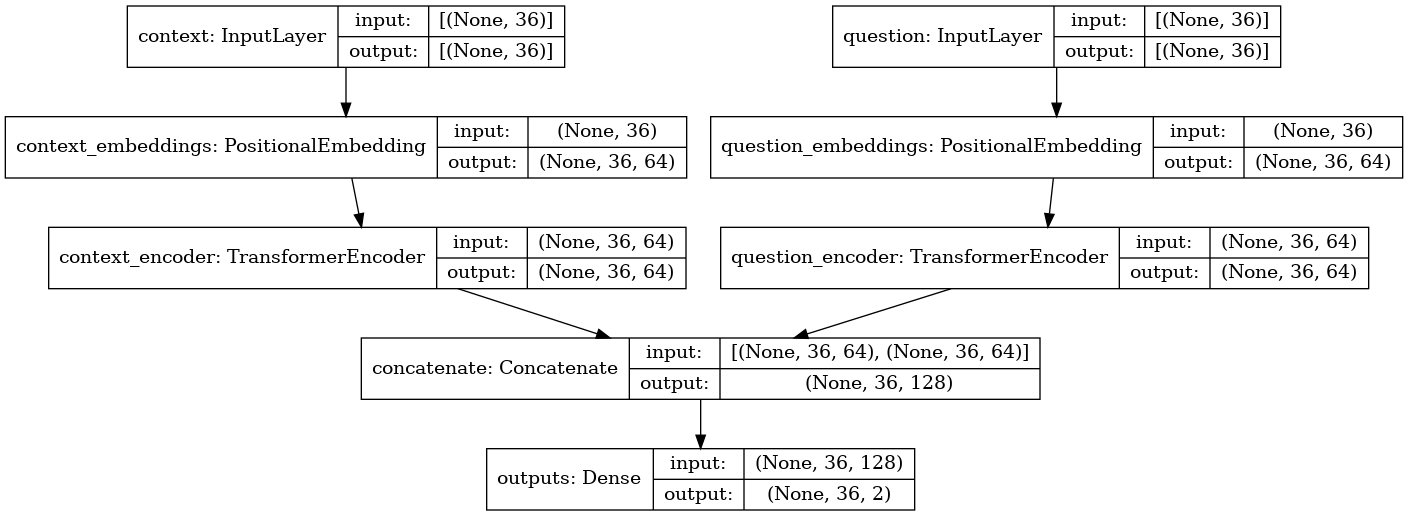

In [9]:
MAX_LEN = 36
EMBED_DIM = 64
DENSE_DIM = 64
NUM_HEADS = 2

context_inp = L.Input(shape=(MAX_LEN, ), name='context')
question_inp = L.Input(shape=(MAX_LEN, ), name='question')

context_emb = PositionalEmbedding(
    MAX_LEN, len(context_tokenizer.word_index)+1, EMBED_DIM, name='context_embeddings'
)(context_inp)
question_emb = PositionalEmbedding(
    MAX_LEN, len(question_tokenizer.word_index)+1, EMBED_DIM, name='question_embeddings'
)(question_inp)

context_emb = TransformerEncoder(EMBED_DIM, DENSE_DIM, NUM_HEADS, name='context_encoder')(context_emb)
question_emb = TransformerEncoder(EMBED_DIM, DENSE_DIM, NUM_HEADS, name='question_encoder')(question_emb)

concat_emb = L.Concatenate(axis=-1, name='concatenate')([context_emb, question_emb])

outputs = L.Dense(2, activation='sigmoid', name='outputs')(concat_emb)

model = keras.Model(inputs=[context_inp, question_inp], outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-4))
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [10]:
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)

history = model.fit(
    [context_train, question_train], ans_vec_train, validation_data=([context_valid, question_valid], ans_vec_valid),
    epochs=25, callbacks=[es, rlp]
)

2022-01-09 09:36:43.125820: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
738/738 [==============================] - 40s 50ms/step - loss: 0.0698 - val_loss: 0.0546
Epoch 2/25
738/738 [==============================] - 37s 50ms/step - loss: 0.0535 - val_loss: 0.0522
Epoch 3/25
738/738 [==============================] - 37s 50ms/step - loss: 0.0505 - val_loss: 0.0523
Epoch 4/25
738/738 [==============================] - 36s 49ms/step - loss: 0.0487 - val_loss: 0.0532

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 5/25
738/738 [==============================] - 37s 50ms/step - loss: 0.0467 - val_loss: 0.0522
Epoch 6/25
738/738 [==============================] - 36s 49ms/step - loss: 0.0464 - val_loss: 0.0522

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 7/25
738/738 [==============================] - 37s 50ms/step - loss: 0.0462 - val_loss: 0.0523
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping


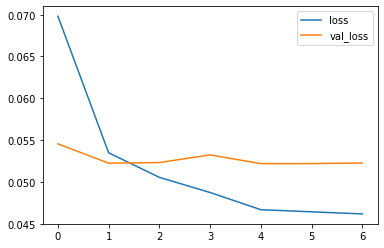

In [11]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot();

# Inference

In [12]:
idx = 28
query_context = context_valid[idx:idx+1]
query_question = question_valid[idx:idx+1]
query_ans_vec = ans_vec_valid[idx:idx+1]
query_ans_beg, query_ans_end  = np.ravel(ans_vec_valid[idx:idx+1].argmax(axis=1))
print('Context:', context_tokenizer.sequences_to_texts(query_context))
print('Question:', question_tokenizer.sequences_to_texts(query_question))
print('Answer:', context_tokenizer.sequences_to_texts([query_context[0][query_ans_beg: query_ans_end+1]]))
pred_ans_beg, pred_ans_end = np.ravel(model([query_context, query_question]).numpy().argmax(axis=1))
print('Predicted Answer:', context_tokenizer.sequences_to_texts([query_context[0][pred_ans_beg: pred_ans_end+1]]))

Context: ['benson loved the macaramber']
Question: ['positive']
Answer: ['loved']
Predicted Answer: ['loved']
